**Imports**

In [4]:
from __future__ import unicode_literals
import sys, os, io
import numpy as np
from sklearn.metrics import confusion_matrix

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
import requests
import json
import pandas as pd
import time
import re
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import SelectKBest, chi2
import json
import pandas as pd
import re
import scipy.sparse as sp

from cuml.svm import SVC


from sklearn.pipeline import Pipeline
import time

import warnings
warnings.filterwarnings('ignore')

import optuna
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

from mlxtend.plotting import plot_learning_curves

**Define classes**

In [5]:
classes=['normal','abusive/offensive']
class_dict = {0: 'Normal',
              2: 'Abusive/Offensive'}

**Preprocessing**

In [6]:

indexes = []
vocab_size = 0


class ARLSTem:
    """
    ARLSTem stemmer : a light Arabic Stemming algorithm without any dictionary.
    Department of Telecommunication & Information Processing. USTHB University,
    Algiers, Algeria.
    ARLSTem.stem(token) returns the Arabic stem for the input token.
    The ARLSTem Stemmer requires that all tokens are encoded using Unicode
    encoding.
    """

    def __init__(self):
        # different Alif with hamza
        self.re_hamzated_alif = re.compile(r"[\u0622\u0623\u0625]")
        self.re_alifMaqsura = re.compile(r"[\u0649]")
        self.re_diacritics = re.compile(r"[\u064B-\u065F]")

        # Alif Laam, Laam Laam, Fa Laam, Fa Ba
        self.pr2 = ["\u0627\u0644", "\u0644\u0644", "\u0641\u0644", "\u0641\u0628"]
        # Ba Alif Laam, Kaaf Alif Laam, Waaw Alif Laam
        self.pr3 = ["\u0628\u0627\u0644", "\u0643\u0627\u0644", "\u0648\u0627\u0644"]
        # Fa Laam Laam, Waaw Laam Laam
        self.pr32 = ["\u0641\u0644\u0644", "\u0648\u0644\u0644"]
        # Fa Ba Alif Laam, Waaw Ba Alif Laam, Fa Kaaf Alif Laam
        self.pr4 = [
            "\u0641\u0628\u0627\u0644",
            "\u0648\u0628\u0627\u0644",
            "\u0641\u0643\u0627\u0644",
        ]

        # Kaf Yaa, Kaf Miim
        self.su2 = ["\u0643\u064A", "\u0643\u0645"]
        # Ha Alif, Ha Miim
        self.su22 = ["\u0647\u0627", "\u0647\u0645"]
        # Kaf Miim Alif, Kaf Noon Shadda
        self.su3 = ["\u0643\u0645\u0627", "\u0643\u0646\u0651"]
        # Ha Miim Alif, Ha Noon Shadda
        self.su32 = ["\u0647\u0645\u0627", "\u0647\u0646\u0651"]

        # Alif Noon, Ya Noon, Waaw Noon
        self.pl_si2 = ["\u0627\u0646", "\u064A\u0646", "\u0648\u0646"]
        # Taa Alif Noon, Taa Ya Noon
        self.pl_si3 = ["\u062A\u0627\u0646", "\u062A\u064A\u0646"]

        # Alif Noon, Waaw Noon
        self.verb_su2 = ["\u0627\u0646", "\u0648\u0646"]
        # Siin Taa, Siin Yaa
        self.verb_pr2 = ["\u0633\u062A", "\u0633\u064A"]
        # Siin Alif, Siin Noon
        self.verb_pr22 = ["\u0633\u0627", "\u0633\u0646"]
        # Lam Noon, Lam Taa, Lam Yaa, Lam Hamza
        self.verb_pr33 = [
            "\u0644\u0646",
            "\u0644\u062A",
            "\u0644\u064A",
            "\u0644\u0623",
        ]
        # Taa Miim Alif, Taa Noon Shadda
        self.verb_suf3 = ["\u062A\u0645\u0627", "\u062A\u0646\u0651"]
        # Noon Alif, Taa Miim, Taa Alif, Waaw Alif
        self.verb_suf2 = [
            "\u0646\u0627",
            "\u062A\u0645",
            "\u062A\u0627",
            "\u0648\u0627",
        ]
        # Taa, Alif, Noon
        self.verb_suf1 = ["\u062A", "\u0627", "\u0646"]


    def stem(self, token):
        """
        call this function to get the word's stem based on ARLSTem .
        """
        try:
            if token is None:
                raise ValueError(
                    "The word could not be stemmed, because \
                                 it is empty !"
                )
            # remove Arabic diacritics and replace some letters with others
            token = self.norm(token)
            # strip common prefixes of the nouns
            pre = self.pref(token)
            if pre is not None:
                token = pre
            # strip the suffixes which are common to nouns and verbs
            token = self.suff(token)
            # transform a plural noun to a singular noun
            ps = self.plur2sing(token)
            if ps is None:
                # transform from the feminine form to the masculine form
                fm = self.fem2masc(token)
                if fm is not None:
                    return fm
                else:
                    if pre is None:  # if the prefixes are not stripped
                        # strip the verb prefixes and suffixes
                        return self.verb(token)
            else:
                return ps
            return token
        except ValueError as e:
            print(e)


    def norm(self, token):
        """
        normalize the word by removing diacritics, replacing hamzated Alif
        with Alif replacing AlifMaqsura with Yaa and removing Waaw at the
        beginning.
        """
        # strip Arabic diacritics
        token = self.re_diacritics.sub("", token)
        # replace Hamzated Alif with Alif bare
        token = self.re_hamzated_alif.sub("\u0627", token)
        # replace alifMaqsura with Yaa
        token = self.re_alifMaqsura.sub("\u064A", token)
        # strip the Waaw from the word beginning if the remaining is 3 letters
        # at least
        if token.startswith("\u0648") and len(token) > 3:
            token = token[1:]
        return token

    def pref(self, token):
        """
        remove prefixes from the words' beginning.
        """
        if len(token) > 5:
            for p3 in self.pr3:
                if token.startswith(p3):
                    return token[3:]
        if len(token) > 6:
            for p4 in self.pr4:
                if token.startswith(p4):
                    return token[4:]
        if len(token) > 5:
            for p3 in self.pr32:
                if token.startswith(p3):
                    return token[3:]
        if len(token) > 4:
            for p2 in self.pr2:
                if token.startswith(p2):
                    return token[2:]


    def suff(self, token):
        """
        remove suffixes from the word's end.
        """
        if token.endswith("\u0643") and len(token) > 3:
            return token[:-1]
        if len(token) > 4:
            for s2 in self.su2:
                if token.endswith(s2):
                    return token[:-2]
        if len(token) > 5:
            for s3 in self.su3:
                if token.endswith(s3):
                    return token[:-3]
        if token.endswith("\u0647") and len(token) > 3:
            token = token[:-1]
            return token
        if len(token) > 4:
            for s2 in self.su22:
                if token.endswith(s2):
                    return token[:-2]
        if len(token) > 5:
            for s3 in self.su32:
                if token.endswith(s3):
                    return token[:-3]
        if token.endswith("\u0646\u0627") and len(token) > 4:
            return token[:-2]
        return token


    def fem2masc(self, token):
        """
        transform the word from the feminine form to the masculine form.
        """
        if token.endswith("\u0629") and len(token) > 3:
            return token[:-1]


    def plur2sing(self, token):
        """
        transform the word from the plural form to the singular form.
        """
        if len(token) > 4:
            for ps2 in self.pl_si2:
                if token.endswith(ps2):
                    return token[:-2]
        if len(token) > 5:
            for ps3 in self.pl_si3:
                if token.endswith(ps3):
                    return token[:-3]
        if len(token) > 3 and token.endswith("\u0627\u062A"):
            return token[:-2]
        if len(token) > 3 and token.startswith("\u0627") and token[2] == "\u0627":
            return token[:2] + token[3:]
        if len(token) > 4 and token.startswith("\u0627") and token[-2] == "\u0627":
            return token[1:-2] + token[-1]


    def verb(self, token):
        """
        stem the verb prefixes and suffixes or both
        """
        vb = self.verb_t1(token)
        if vb is not None:
            return vb
        vb = self.verb_t2(token)
        if vb is not None:
            return vb
        vb = self.verb_t3(token)
        if vb is not None:
            return vb
        vb = self.verb_t4(token)
        if vb is not None:
            return vb
        vb = self.verb_t5(token)
        if vb is not None:
            return vb
        return self.verb_t6(token)


    def verb_t1(self, token):
        """
        stem the present prefixes and suffixes
        """
        if len(token) > 5 and token.startswith("\u062A"):  # Taa
            for s2 in self.pl_si2:
                if token.endswith(s2):
                    return token[1:-2]
        if len(token) > 5 and token.startswith("\u064A"):  # Yaa
            for s2 in self.verb_su2:
                if token.endswith(s2):
                    return token[1:-2]
        if len(token) > 4 and token.startswith("\u0627"):  # Alif
            # Waaw Alif
            if len(token) > 5 and token.endswith("\u0648\u0627"):
                return token[1:-2]
            # Yaa
            if token.endswith("\u064A"):
                return token[1:-1]
            # Alif
            if token.endswith("\u0627"):
                return token[1:-1]
            # Noon
            if token.endswith("\u0646"):
                return token[1:-1]
        # ^Yaa, Noon$
        if len(token) > 4 and token.startswith("\u064A") and token.endswith("\u0646"):
            return token[1:-1]
        # ^Taa, Noon$
        if len(token) > 4 and token.startswith("\u062A") and token.endswith("\u0646"):
            return token[1:-1]


    def verb_t2(self, token):
        """
        stem the future prefixes and suffixes
        """
        if len(token) > 6:
            for s2 in self.pl_si2:
                # ^Siin Taa
                if token.startswith(self.verb_pr2[0]) and token.endswith(s2):
                    return token[2:-2]
            # ^Siin Yaa, Alif Noon$
            if token.startswith(self.verb_pr2[1]) and token.endswith(self.pl_si2[0]):
                return token[2:-2]
            # ^Siin Yaa, Waaw Noon$
            if token.startswith(self.verb_pr2[1]) and token.endswith(self.pl_si2[2]):
                return token[2:-2]
        # ^Siin Taa, Noon$
        if (
            len(token) > 5
            and token.startswith(self.verb_pr2[0])
            and token.endswith("\u0646")
        ):
            return token[2:-1]
        # ^Siin Yaa, Noon$
        if (
            len(token) > 5
            and token.startswith(self.verb_pr2[1])
            and token.endswith("\u0646")
        ):
            return token[2:-1]


    def verb_t3(self, token):
        """
        stem the present suffixes
        """
        if len(token) > 5:
            for su3 in self.verb_suf3:
                if token.endswith(su3):
                    return token[:-3]
        if len(token) > 4:
            for su2 in self.verb_suf2:
                if token.endswith(su2):
                    return token[:-2]
        if len(token) > 3:
            for su1 in self.verb_suf1:
                if token.endswith(su1):
                    return token[:-1]


    def verb_t4(self, token):
        """
        stem the present prefixes
        """
        if len(token) > 3:
            for pr1 in self.verb_suf1:
                if token.startswith(pr1):
                    return token[1:]
            if token.startswith("\u064A"):
                return token[1:]


    def verb_t5(self, token):
        """
        stem the future prefixes
        """
        if len(token) > 4:
            for pr2 in self.verb_pr22:
                if token.startswith(pr2):
                    return token[2:]
            for pr2 in self.verb_pr2:
                if token.startswith(pr2):
                    return token[2:]
        return token


    def verb_t6(self, token):
        """
        stem the order prefixes
        """
        if len(token) > 4:
            for pr3 in self.verb_pr33:
                if token.startswith(pr3):
                    return token[2:]
        return token



class Preprocessing:
    def __init__(self):
        self.punctuations = re.compile(r'[\u0021\u002C\u002D\u002E\u003A\u003B\u003F\u066B\u066C\u06D4\u061F\u060C\u000A\u000D]')
        emoj_file = io.open(_CORPUS_PATH + '/kaggle/input/nlp-paper/emoj.txt', encoding='utf-8')
        self.emojis = emoj_file.read()
        emoj_file.close()
        self.stemmer = ARLSTem()
        #self.linefeed = re.compile(r'[\u000A\u000D]')

    def text_preprocessing(self, text):
        # strip punctuation marks
        text = self.punctuations.sub('', text)
        text = self.remove_emojis(text)
        text = self.remove_hashtag(text)
        text = self.remove_letter_duplication(text)
        text = self.stemming(text)
        return text

    def stemming(self, text):
        words = text.split()
        new_text = ''
        for word in words:
            new_text += self.stemmer.stem(word) + ' '
        return new_text

    def remove_hashtag(self, text):
        return re.sub(r'#.+ ', ' ', text)

    def remove_emojis(self, text):
        for emo in self.emojis:
            text = text.replace(emo, '')
        return text

    def remove_letter_duplication(self, text):
        new_text = re.sub(r'\u0627\u0627+', '\u0627', text) #ARABIC LETTER ALEF
        new_text = re.sub(r'\u0628\u0628+', '\u0628', new_text) #ARABIC LETTER BEH
        new_text = re.sub(r'\u0629\u0629+', '\u0629', new_text) #ARABIC LETTER TEH MARBUTA
        new_text = re.sub(r'\u062A\u062A+', '\u062A', new_text) #ARABIC LETTER TEH *
        new_text = re.sub(r'\u062B\u062B+', '\u062B', new_text) #ARABIC LETTER THEH
        new_text = re.sub(r'\u062C\u062C+', '\u062C', new_text) #ARABIC LETTER JEEM
        new_text = re.sub(r'\u062D\u062D+', '\u062D', new_text) #ARABIC LETTER HAH
        new_text = re.sub(r'\u062E\u062E+', '\u062E', new_text) #ARABIC LETTER KHAH
        new_text = re.sub(r'\u062F\u062F+', '\u062F', new_text) #ARABIC LETTER DAL

        new_text = re.sub(r'\u0630\u0630+', '\u0630', new_text) #ARABIC LETTER THAL
        new_text = re.sub(r'\u0631\u0631+', '\u0631', new_text) #ARABIC LETTER REH
        new_text = re.sub(r'\u0632\u0632+', '\u0632', new_text) #ARABIC LETTER ZAIN
        new_text = re.sub(r'\u0633\u0633+', '\u0633', new_text) #ARABIC LETTER SEEN
        new_text = re.sub(r'\u0634\u0634+', '\u0634', new_text) #ARABIC LETTER SHEEN
        new_text = re.sub(r'\u0635\u0635+', '\u0635', new_text) #ARABIC LETTER SAD
        new_text = re.sub(r'\u0636\u0636+', '\u0636', new_text) #ARABIC LETTER DAD
        new_text = re.sub(r'\u0637\u0637+', '\u0637', new_text) #ARABIC LETTER TAH
        new_text = re.sub(r'\u0638\u0638+', '\u0638', new_text) #ARABIC LETTER ZAH
        new_text = re.sub(r'\u0639\u0639+', '\u0639', new_text) #ARABIC LETTER AIN *
        new_text = re.sub(r'\u063A\u063A+', '\u063A', new_text) #ARABIC LETTER GHAIN

        new_text = re.sub(r'\u0641\u0641+', '\u0641', new_text) #ARABIC LETTER FEH
        new_text = re.sub(r'\u0642\u0642+', '\u0642', new_text) #ARABIC LETTER QAF
        new_text = re.sub(r'\u0643\u0643+', '\u0643', new_text) #ARABIC LETTER KAF
        new_text = re.sub(r'\u0644\u0644+', '\u0644', new_text) #ARABIC LETTER LAM
        new_text = re.sub(r'\u0645\u0645+', '\u0645', new_text) #ARABIC LETTER MEEM
        new_text = re.sub(r'\u0646\u0646+', '\u0646', new_text) #ARABIC LETTER NOON
        new_text = re.sub(r'\u0647\u0647+', '\u0647\u0647\u0647', new_text) #ARABIC LETTER HEH *
        new_text = re.sub(r'(\u0647\u0627)+', '\u0647\u0647\u0647', new_text) #ARABIC LETTER HEH-Alif *
        new_text = re.sub(r'\u0648\u0648+', '\u0648', new_text) #ARABIC LETTER WAW
        new_text = re.sub(r'\u0649\u0649+', '\u0649', new_text) #ARABIC LETTER ALEF MAKSURA
        new_text = re.sub(r'\u064A\u064A+', '\u064A', new_text) #ARABIC LETTER YEH
        return new_text
        
################################################# Load the dataset#################################################
prep = Preprocessing()
latin_letters = re.compile(r'[abcdefghijklmnopqrstuvwxyz]+')

df = pd.read_csv('keras_test_pre_2c_trans_.txt', sep=',') 
x_text = df['content'].values.astype('U')
y_test = df['label'].values
for txt in range(len(x_text)):
    x_text[txt] = prep.text_preprocessing(x_text[txt])


df = pd.read_csv('keras_train_pre_2c_trans_.txt', sep=',') 
x_train = df['content'].values.astype('U')
y_train = df['label'].values
for txt in range(len(x_train)):
    x_train[txt] = prep.text_preprocessing(x_train[txt])

**Feature extraction**

In [8]:

################################################# Feature Extraction #################################################

print("[INFO]  Start Feature extaction...")

count_vect = CountVectorizer()
tfidf_transformer = TfidfTransformer()

X_train_counts = count_vect.fit_transform(x_train)
X_new_counts = count_vect.transform(x_text)


trainX = tfidf_transformer.fit_transform(X_train_counts)
testX = tfidf_transformer.transform(X_new_counts)

print("[INFO]  Finished Feature extaction...")

trainX = trainX.todense()

testX = testX.todense()

[INFO]  Start Feature extaction...
[INFO]  Finished Feature extaction...


**Preprocessing with default SVM, no feature selection**

################################################################################
################################################################################
---Training time 5.796914100646973 seconds ---
              precision    recall  f1-score   support

           0     0.9883    0.9846    0.9864      4102
           2     0.9834    0.9873    0.9853      3772

    accuracy                         0.9859      7874
   macro avg     0.9858    0.9860    0.9859      7874
weighted avg     0.9859    0.9859    0.9859      7874

Training accuracy SVM: 98.5903%
Training f1 SVM: 98.5880%
[INFO] evaluating...
---Prediction time SVM 0.23348641395568848 seconds ---
              precision    recall  f1-score   support

           0     0.7979    0.8188    0.8082       458
           2     0.7946    0.7716    0.7829       416

    accuracy                         0.7963       874
   macro avg     0.7962    0.7952    0.7956       874
weighted avg     0.7963    0.7963    0.7962       874

Acc

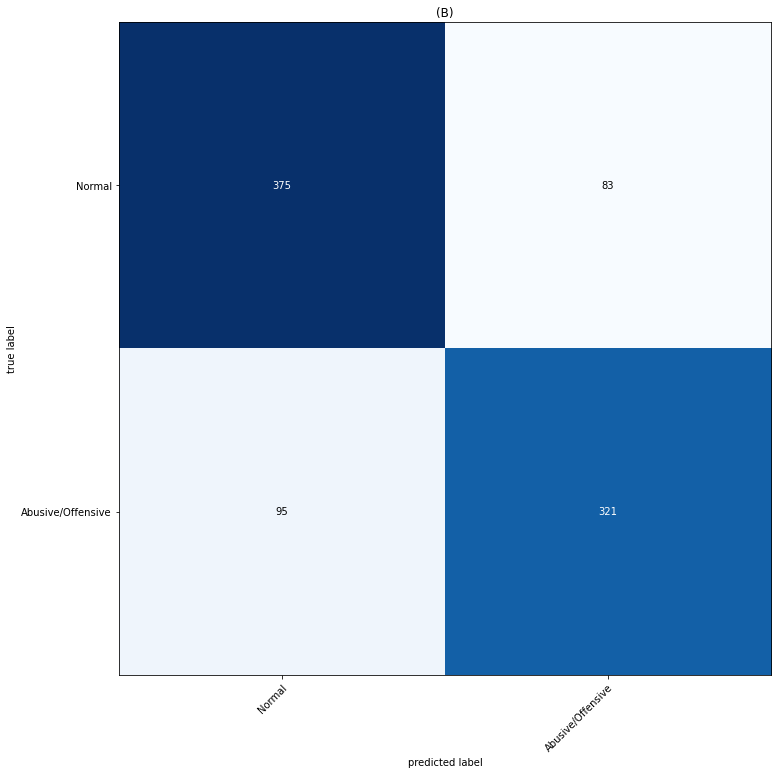

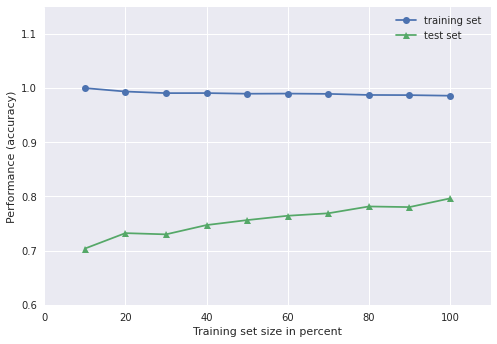

In [9]:
print("################################################################################")
print("################################################################################")

################################################# Classification #################################################

# Use a RBF SVC
svm = SVC()



start_time = time.time()
model = svm.fit(trainX, y_train)

# Get Training time
print("---Training time %s seconds ---" % (time.time() - start_time))

start_time = time.time()
predictions = model.predict(trainX)


report = classification_report(y_train, predictions,digits=4)
cm = confusion_matrix(y_train, predictions)

print(report)

acc_train = accuracy_score(y_train, predictions)
print("Training accuracy SVM: %.4f%%" % (acc_train * 100.0))


f1 = f1_score(y_train, predictions,average='macro')
print("Training f1 SVM: %.4f%%" % (f1 * 100.0))

print("[INFO] evaluating...")

start_time = time.time()
predictions = model.predict(testX)

# Get Testing time
print("---Prediction time SVM %s seconds ---" % (time.time() - start_time))

report = classification_report(y_test, predictions,digits=4)
cm = confusion_matrix(y_test, predictions)

print(report)

acc_test = accuracy_score(y_test, predictions)
print("Accuracy : %.4f%%" % (acc_test * 100.0))

f1_mac_test = f1_score(y_test, predictions,average='macro')
print("Testing macro f1 : %.4f%%" % (f1_mac_test * 100.0))

f1_mic_test = f1_score(y_test, predictions,average='micro')
print("Testing micro f1 : %.4f%%" % (f1_mic_test * 100.0))


fig, ax = plot_confusion_matrix(
    conf_mat=cm,figsize = (12, 12),
    class_names=class_dict.values(),
)

ax.set_title('(B)')
plt.savefig('cm_pre.png')

plt.show()   



plot_learning_curves(trainX, y_train, testX, y_test, model,scoring ='accuracy',style = 'seaborn',print_model=False)
plt.savefig('lear_curve_pre.png')

plt.show()


**Preprocessing with Optimized chi2**

################################################################################
################################################################################
---Training time of Non-optimised SVM 0.7164955139160156 seconds ---
              precision    recall  f1-score   support

           0     0.9373    0.8194    0.8743      4102
           2     0.8272    0.9403    0.8801      3772

    accuracy                         0.8773      7874
   macro avg     0.8822    0.8799    0.8772      7874
weighted avg     0.8845    0.8773    0.8771      7874

Training accuracy of optimised SVM: 87.7318%
Training macro f1 of ptimised SVM: 87.7249%
Training micro f1 of ptimised SVM: 87.7318%
[INFO] evaluating...
---Prediction time of Non-optimised SVM 0.01932215690612793 seconds ---
              precision    recall  f1-score   support

           0     0.8600    0.7642    0.8092       458
           2     0.7687    0.8630    0.8131       416

    accuracy                         0.8112       87

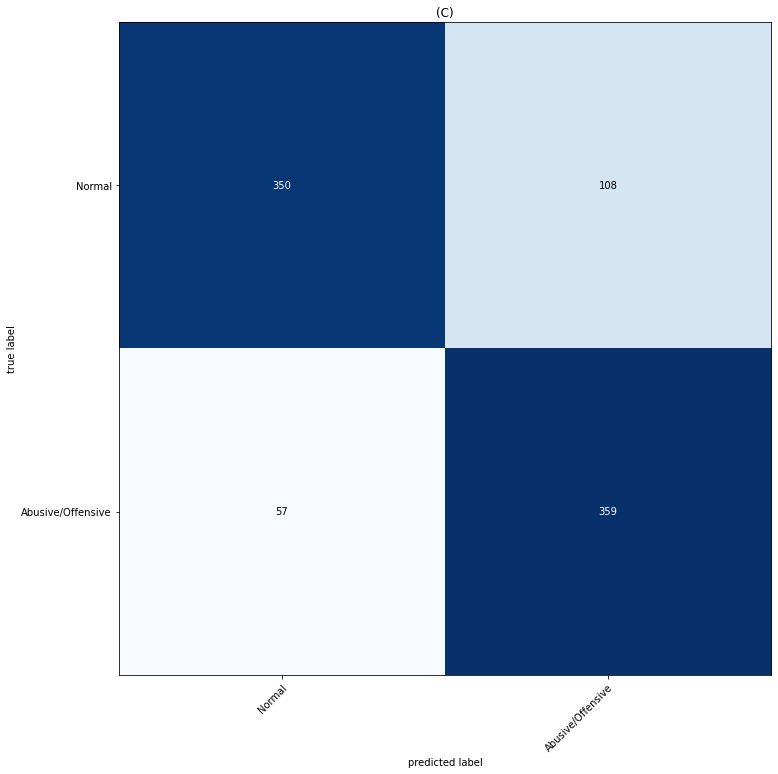

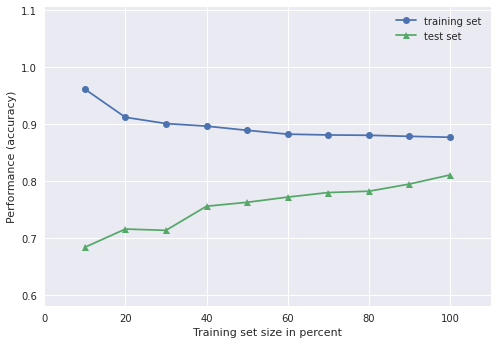

In [16]:
print("################################################################################")
print("################################################################################")

################################################# Classification #################################################


# Use Chi2 stats to reduce dimensionality
# and improve generalization

# The number of selected features suggested by TPE
# is 872


selec = SelectKBest(chi2, k = 872)

# Use a default RBF SVC


svm = SVC()

pipeline = Pipeline(steps=[('selec', selec), ('svm', svm)])


start_time = time.time()
model = pipeline.fit(trainX, y_train)

# Get Training time
print("---Training time SVM %s seconds ---" % (time.time() - start_time))

start_time = time.time()
predictions = model.predict(trainX)


report = classification_report(y_train, predictions,digits=4)
cm = confusion_matrix(y_train, predictions)

print(report)

acc_train = accuracy_score(y_train, predictions)
print("Training accuracy of optimised SVM: %.4f%%" % (acc_train * 100.0))


f1 = f1_score(y_train, predictions,average='macro')
print("Training macro f1 of ptimised SVM: %.4f%%" % (f1 * 100.0))

f1 = f1_score(y_train, predictions,average='micro')
print("Training micro f1  SVM: %.4f%%" % (f1 * 100.0))

print("[INFO] evaluating...")

start_time = time.time()
predictions = model.predict(testX)

# Get Testing time
print("---Prediction time of  SVM %s seconds ---" % (time.time() - start_time))

report = classification_report(y_test, predictions,digits=4)
cm = confusion_matrix(y_test, predictions)

print(report)

acc_test = accuracy_score(y_test, predictions)
print("Accuracy: %.4f%%" % (acc_test * 100.0))

f1_mac_test = f1_score(y_test, predictions,average='macro')
print("Testing macro f1 : %.4f%%" % (f1_mac_test * 100.0))

f1_mic_test = f1_score(y_test, predictions,average='micro')
print("Testing micro f1 : %.4f%%" % (f1_mic_test * 100.0))



class_dict = {0: 'Normal',
              2: 'Abusive/Offensive'}

fig, ax = plot_confusion_matrix(
    conf_mat=cm,figsize = (12, 12),
    class_names=class_dict.values(),
)

ax.set_title('(C)')
plt.savefig('cm_fs.png')

plt.show()         
                   
    
plot_learning_curves(trainX, y_train, testX, y_test, model,scoring ='accuracy',style = 'seaborn',print_model=False)
plt.savefig('chi2_C.png')
plt.show()

**Preprocessing with Optimized RBF-SVM**

################################################################################
################################################################################
---Training time SVM 1.5795886516571045 seconds ---
              precision    recall  f1-score   support

           0     0.9980    0.9959    0.9969      4102
           2     0.9955    0.9979    0.9967      3772

    accuracy                         0.9968      7874
   macro avg     0.9968    0.9969    0.9968      7874
weighted avg     0.9968    0.9968    0.9968      7874

Training accuracy: 99.6825%
Training f1 SVM: 99.6820%
[INFO] evaluating...
---Prediction time SVM 0.12103486061096191 seconds ---
              precision    recall  f1-score   support

           0     0.8182    0.8057    0.8119       458
           2     0.7896    0.8029    0.7962       416

    accuracy                         0.8043       874
   macro avg     0.8039    0.8043    0.8040       874
weighted avg     0.8046    0.8043    0.8044       874

Ac

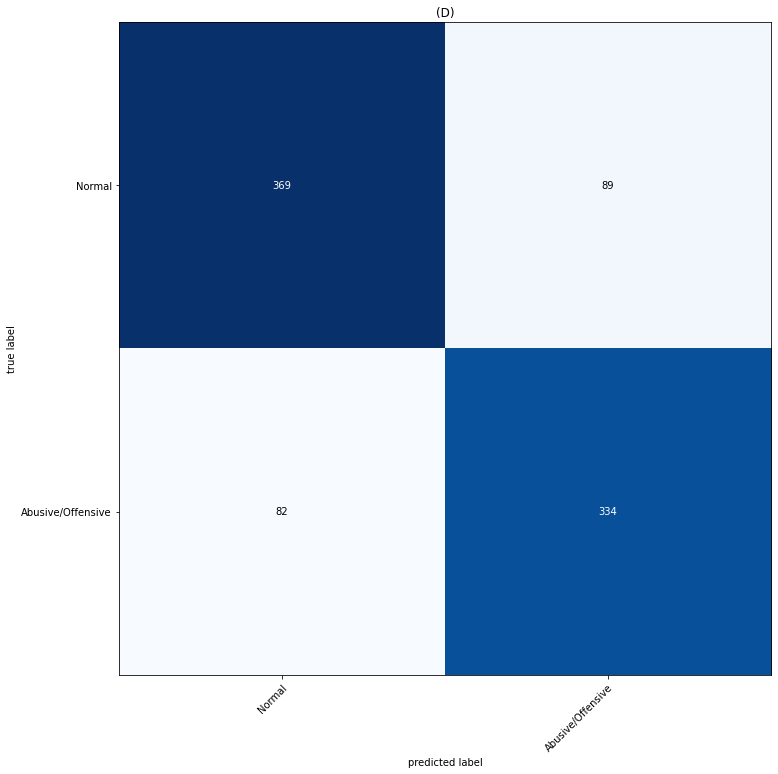

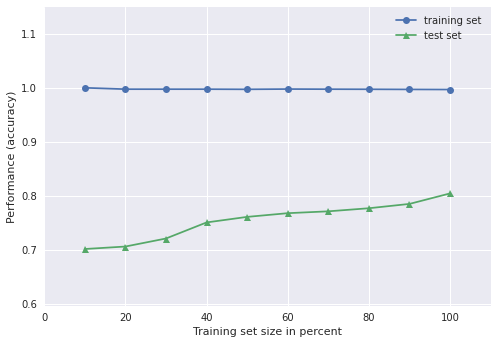

In [12]:
print("################################################################################")
print("################################################################################")




# Use a RBF SVC
# The best hyperparameters suggested by TPE algorithm

param = {'C': 214.13302531097457, 'gamma': 0.4986306845614277}
svm = SVC(**param)



start_time = time.time()
model = svm.fit(trainX, y_train)

# Get Training time
print("---Training time SVM %s seconds ---" % (time.time() - start_time))

start_time = time.time()
predictions = model.predict(trainX)


report = classification_report(y_train, predictions,digits=4)
cm = confusion_matrix(y_train, predictions)

print(report)

acc_train = accuracy_score(y_train, predictions)
print("Training accuracy: %.4f%%" % (acc_train * 100.0))


f1 = f1_score(y_train, predictions,average='macro')
print("Training f1 SVM: %.4f%%" % (f1 * 100.0))

print("[INFO] evaluating...")

start_time = time.time()
predictions = model.predict(testX)

# Get Testing time
print("---Prediction time SVM %s seconds ---" % (time.time() - start_time))

report = classification_report(y_test, predictions,digits=4)
cm = confusion_matrix(y_test, predictions)

print(report)

acc_test = accuracy_score(y_test, predictions)
print("Accuracy : %.4f%%" % (acc_test * 100.0))

f1_mac_test = f1_score(y_test, predictions,average='macro')
print("Testing macro f1 : %.4f%%" % (f1_mac_test * 100.0))

f1_mic_test = f1_score(y_test, predictions,average='micro')
print("Testing micro f1 : %.4f%%" % (f1_mic_test * 100.0))


fig, ax = plot_confusion_matrix(
    conf_mat=cm,figsize = (12, 12),
    class_names=class_dict.values(),
)

ax.set_title('(D)')

plt.savefig('cm_hpo.png')

plt.show()         
                     
plot_learning_curves(trainX, y_train, testX, y_test, model,scoring ='accuracy',style = 'seaborn',print_model=False)
plt.savefig('lear_curve_svm_D.png')
plt.show()

**Preprocessing with optimised chi2**

################################################################################
################################################################################
---Training time SVM 0.9866623878479004 seconds ---
              precision    recall  f1-score   support

           0     0.9373    0.8194    0.8743      4102
           2     0.8272    0.9403    0.8801      3772

    accuracy                         0.8773      7874
   macro avg     0.8822    0.8799    0.8772      7874
weighted avg     0.8845    0.8773    0.8771      7874

Training accuracy SVM: 87.7318%
Training macro f1 SVM: 87.7249%
Training micro f1 SVM: 87.7318%
[INFO] evaluating...
---Prediction time SVM 0.019313335418701172 seconds ---
              precision    recall  f1-score   support

           0     0.8600    0.7642    0.8092       458
           2     0.7687    0.8630    0.8131       416

    accuracy                         0.8112       874
   macro avg     0.8143    0.8136    0.8112       874
weighted avg  

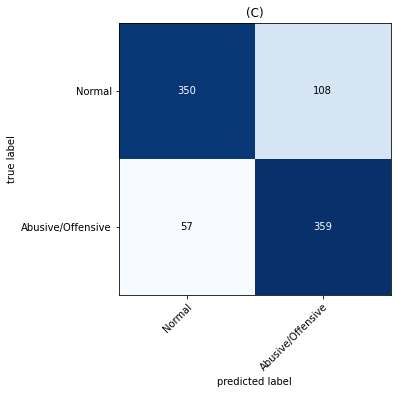

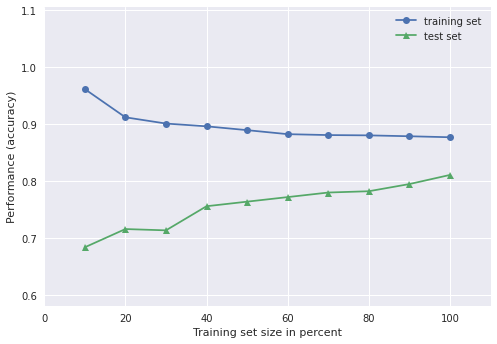

In [15]:
print("################################################################################")
print("################################################################################")

################################################# Classification #################################################

# Use Chi2 stats to reduce dimensionality
# and improve generalization
# 873

selec = SelectKBest(chi2, k = 873)

# Use a Defaul RBF SVC

svm = SVC()

pipeline = Pipeline(steps=[('selec', selec), ('svm', svm)])


start_time = time.time()
model = pipeline.fit(trainX, y_train)

# Get Training time
print("---Training time SVM %s seconds ---" % (time.time() - start_time))

start_time = time.time()
predictions = model.predict(trainX)


report = classification_report(y_train, predictions,digits=4)
cm = confusion_matrix(y_train, predictions)

print(report)

acc_train = accuracy_score(y_train, predictions)
print("Training accuracy SVM: %.4f%%" % (acc_train * 100.0))


f1 = f1_score(y_train, predictions,average='macro')
print("Training macro f1 SVM: %.4f%%" % (f1 * 100.0))

f1 = f1_score(y_train, predictions,average='micro')
print("Training micro f1 SVM: %.4f%%" % (f1 * 100.0))

print("[INFO] evaluating...")

start_time = time.time()
predictions = model.predict(testX)

# Get Testing time
print("---Prediction time SVM %s seconds ---" % (time.time() - start_time))

report = classification_report(y_test, predictions,digits=4)
cm = confusion_matrix(y_test, predictions)

print(report)

acc_test = accuracy_score(y_test, predictions)
print("Accuracy : %.4f%%" % (acc_test * 100.0))

f1_mac_test = f1_score(y_test, predictions,average='macro')
print("Testing macro f1: %.4f%%" % (f1_mac_test * 100.0))

f1_mic_test = f1_score(y_test, predictions,average='micro')
print("Testing micro f1: %.4f%%" % (f1_mic_test * 100.0))



fig, ax = plot_confusion_matrix(
    conf_mat=cm,figsize = (5, 5),
    class_names=class_dict.values(),
)

ax.set_title('(C)')
plt.savefig('cm_fs.png')

plt.show()         
                   
    
plot_learning_curves(trainX, y_train, testX, y_test, model,scoring ='accuracy',style = 'seaborn',print_model=False)
plt.savefig('chi2.png')
plt.show()

**Combined optimized chi2 and svm**

################################################################################
################################################################################
---Training time of Non-optimised SVM 1.0683517456054688 seconds ---
              precision    recall  f1-score   support

           0     0.9268    0.7933    0.8549      4102
           2     0.8056    0.9319    0.8642      3772

    accuracy                         0.8597      7874
   macro avg     0.8662    0.8626    0.8595      7874
weighted avg     0.8688    0.8597    0.8593      7874

Training accuracy of optimised SVM: 85.9665%
Training macro f1 of ptimised SVM: 85.9510%
Training micro f1 of ptimised SVM: 85.9665%
[INFO] evaluating...
---Prediction time of Non-optimised SVM 0.018774747848510742 seconds ---
              precision    recall  f1-score   support

           0     0.8706    0.7489    0.8052       458
           2     0.7604    0.8774    0.8147       416

    accuracy                         0.8101       8

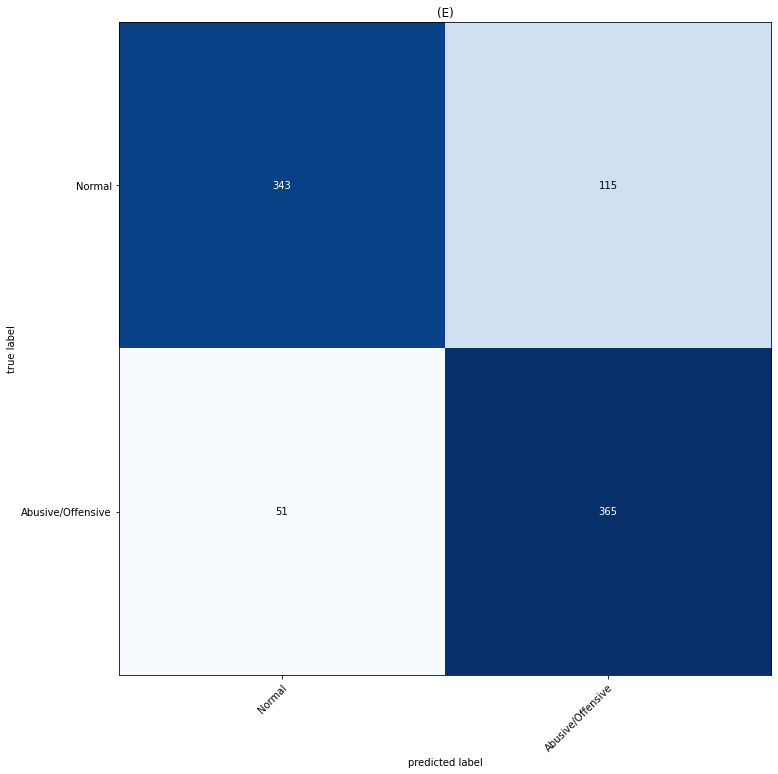

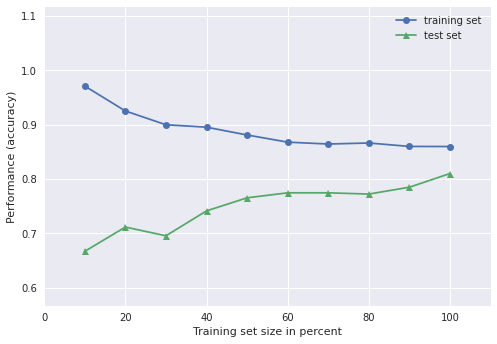

In [13]:

print("################################################################################")
print("################################################################################")

################################################# Classification #################################################


# Use Chi2 stats to reduce dimensionality
# and improve generalization

# The number of selected features suggested by TPE algorithm
# is 886

selec = SelectKBest(chi2, k=886)

# Use a RBF SVC
# The best hyperparameters suggested by TPE algorithm


par = {'C': 216.18604096063314, 'gamma': 0.024683250245202046}

svm = SVC(**par)

pipeline = Pipeline(steps=[('selec', selec), ('svm', svm)])


start_time = time.time()
model = pipeline.fit(trainX, y_train)

# Get Training time
print("---Training time  SVM %s seconds ---" % (time.time() - start_time))

start_time = time.time()
predictions = model.predict(trainX)


report = classification_report(y_train, predictions,digits=4)
cm = confusion_matrix(y_train, predictions)

print(report)

acc_train = accuracy_score(y_train, predictions)
print("Training accuracy  SVM: %.4f%%" % (acc_train * 100.0))


f1 = f1_score(y_train, predictions,average='macro')
print("Training macro f1  SVM: %.4f%%" % (f1 * 100.0))

f1 = f1_score(y_train, predictions,average='micro')
print("Training micro f1  SVM: %.4f%%" % (f1 * 100.0))

print("[INFO] evaluating...")

start_time = time.time()
predictions = model.predict(testX)

# Get Testing time
print("---Prediction time SVM %s seconds ---" % (time.time() - start_time))

report = classification_report(y_test, predictions,digits=4)
cm = confusion_matrix(y_test, predictions)

print(report)

acc_test = accuracy_score(y_test, predictions)
print("Accuracy : %.4f%%" % (acc_test * 100.0))

f1_mac_test = f1_score(y_test, predictions,average='macro')
print("Testing macro f1 : %.4f%%" % (f1_mac_test * 100.0))

f1_mic_test = f1_score(y_test, predictions,average='micro')
print("Testing micro f1 : %.4f%%" % (f1_mic_test * 100.0))


fig, ax = plot_confusion_matrix(
    conf_mat=cm,figsize = (12, 12),
    class_names=class_dict.values(),
)

ax.set_title('(E)')
plt.savefig('cm_fs_hpo.png')

plt.show()         
                     




plot_learning_curves(trainX, y_train, testX, y_test, model,scoring ='accuracy',style = 'seaborn',print_model=False)
plt.savefig('lear_curve_hpofs_E.png')
plt.show()
